# Self-Organising Maps

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import matplotlib.lines as mlines
from our_som1C import SOM


In [2]:
# reading data
data = pd.read_csv("cash-crops-nepal.csv")
# visualize some data
data.iloc[:10,:]

,Year AD,Year BS,Crop,Area,Production,Yield
0,1984/85,2041/42,OILSEED,127820,84030,657
1,1985/86,2042/43,OILSEED,137920,78390,568
2,1986/87,2043/44,OILSEED,142890,82500,577
3,1987/88,2044/45,OILSEED,151490,94370,623
4,1988/89,2045/46,OILSEED,154860,99190,641
5,1989/90,2046/47,OILSEED,153660,98060,638
6,1990/91,2047/48,OILSEED,156310,92140,589
7,1991/92,2048/49,OILSEED,154570,87840,568
8,1992/93,2049/50,OILSEED,165240,93690,567
9,1993/94,2050/51,OILSEED,177486,107535,606


In [3]:
data.shape

(105, 6)

In [4]:
# What are the different crops
print(data.iloc[:,2].unique())

['OILSEED' 'POTATO' 'TOBACCO' 'SUGARCANE' 'JUTE']


We will not use "Crop" labels for training SOM. But we will use it to check if the clustering by SOM worked fine or not. We will also drop the “Year AD” and “Year BS” columns.

In [5]:
# shuffling data
agri_data = data.iloc[np.random.permutation(len(data))]
trunc_data = agri_data[["Area", "Production", "Yield"]]
trunc_data.iloc[:10,:]

,Area,Production,Yield
56,4422,3911,884
52,6028,5447,904
32,106000,898350,8475
47,7610,6600,867
73,43583,1469214,33711
28,85300,732860,8592
27,84280,738030,8757
72,37785,1293092,34222
57,4283,3809,889
62,3003,3016,1004


In [6]:
# (custom choice for) normalizing data
trunc_data = trunc_data / trunc_data.max()
trunc_data.iloc[:10,:]

,Area,Production,Yield
56,0.023221,0.001646,0.021981
52,0.031655,0.002292,0.022478
32,0.556638,0.378077,0.210732
47,0.039962,0.002778,0.021558
73,0.228867,0.618329,0.838228
28,0.447936,0.308429,0.213641
27,0.442580,0.310605,0.217744
72,0.198420,0.544207,0.850934
57,0.022491,0.001603,0.022105
62,0.015770,0.001269,0.024965


## Training SOM

Now let’s train the data in a 3 x 3 SOM network using 3 input features. 

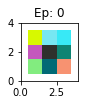

In [7]:
# som = SOM(x_size, y_size, num_features)
agri_som = SOM(3,3,3)

# Initial weights
init_fig = plt.figure()
agri_som.show_plot(init_fig, 1, 0)
plt.show()

Random weights (3 features) are given to each of 9 (3×3) neurons. The above figure shows how the neural network looks like in the beginning.

Notice: 

- after 60 Epochs, the network changed from random colors (initialization) to nearly constant color; this means that initial neighbourhood is large, so each neuron’s weight are being adjusted according to data.

- Slowly, the network develops different color according to input data structures/patterns, but, you can notice similar colors are neighbors to one another.

- Since there was a random initialization, the positions of colors may change but the topology will be preserved.

## Prediction and Analysis

In [8]:
def predict(df, agri_som):
    """
    finds the Best Matching Unit for each data sample.
    Thus, the neuron with closest distance from data sample.
    
    Args:
        df (pd.DataFrame): df to be updated
        agri_som (obj): model

    Returns:
        pd.DataFrame: updated df
    """
    bmu, bmu_idx = agri_som.find_bmu(df.values)
    df['bmu'] = bmu
    df['bmu_idx'] = bmu_idx
    return df


In [9]:
def arrange_data(agri_som):
    """
    Fetch BMU of data samples and append them to the filtered agri_dataset    

    Args:
        agri_som (object): SOM model

    Returns:
        pd.DataFrame: updated agri_data with BMU
    """
    clustered_df = trunc_data.apply(predict, axis=1, agri_som=agri_som)
    joined_df = agri_data.join(clustered_df, rsuffix="_norm")
    return joined_df

In [10]:
def external_purity(df):
    """Purity measures the purity of clusters with respect to ground-truth class labels. To compute the purity of a clustering Q, 
    each cluster is assigned to the class which is most frequent in the cluster, and then the accuracy of this assignment is measured 
    by counting the number of correctly assigned points and dividing by the total number of points:

    Args:
        df (pd.DataFrame): joined training set with bmu positions and weights
    """

    # proper representation of column
    df['bmu_idx'] = df['bmu_idx'].apply(lambda k: str(k))
    df['bmu'] = df['bmu'].apply(lambda k: k[0])

    # fetch number of different samples associated to each cluster.
    clusters = df.value_counts(subset=['Crop', 'bmu_idx']).reset_index() 
    clusters.rename(columns={0:'count'}, inplace=True)

    total = np.sum(clusters['count'])  # compute total number of points

    # assign class which is most frequent in the cluster. highest count of that specific crop type in cluster
    cluster_dominated = clusters.groupby(by=['Crop']).max().reset_index()
    total_correct = np.sum(cluster_dominated['count'])  # compute total number of correctly clustered
    
    return total_correct/total
    

In [11]:
def visualize(joined_df, f,p,q,  epochs, agri_som):
    fig = plt.figure()
    # setup axes
    ax = fig.add_subplot(111)
    scale = 50
    ax.set_xlim((0, agri_som.net.shape[0]*scale))
    ax.set_ylim((0, agri_som.net.shape[1]*scale))
    if p!=2:
        ax.set_title("Neighbourhood function: "+f+" , epochs: "+str(epochs)+" , p: "+str(p))
    elif p == 2 and q!=1 :
        ax.set_title("Neighbourhood function: "+f+" , epochs: "+str(epochs)+" , q: "+str(q))
    else:
        ax.set_title("Neighbourhood function: "+f+" , epochs: "+str(epochs)+" , p: "+str(p)+" , q: "+str(q))
    for x in range(0, agri_som.net.shape[0]):
        for y in range(0, agri_som.net.shape[1]):
            ax.add_patch(patches.Rectangle((x*scale, y*scale), scale, scale,
                         facecolor='white',
                         edgecolor='grey'))
    legend_map = {}

    for index, row in joined_df.iterrows():
        x_cor = row['bmu_idx'][0] * scale
        y_cor = row['bmu_idx'][1] * scale
        x_cor = np.random.randint(x_cor, x_cor + scale)
        y_cor = np.random.randint(y_cor, y_cor + scale)
        color = row['bmu'][0]
        marker = "$\\ " + row['Crop'][0]+"$"
        marker = marker.lower()
        ax.plot(x_cor, y_cor, color=color, marker=marker, markersize=10)
        label = row['Crop']
        if not label in legend_map:
            legend_map[label] =  mlines.Line2D([], [], color='black', marker=marker, linestyle='None',
                              markersize=10, label=label)
    plt.legend(handles=list(legend_map.values()), bbox_to_anchor=(1, 1))
    plt.show()
    return joined_df

In [12]:
"""
executes SOM for epochs [5, 10, 20, 30, 40, 50]
computes external_purity for each instance
"""

external_purities_5 = []
def run_5(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 5 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']

    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others

    agri_som.train(trunc_data.values,
          num_epochs=5,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_5.append(external_purity(joined_df))
    

external_purities_10 = []
def run_10(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 10 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']

    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others
    
    agri_som.train(trunc_data.values,
          num_epochs=10,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_10.append(external_purity(joined_df))

external_purities_20 = []
def run_20(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 20 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others

    agri_som.train(trunc_data.values,
          num_epochs=20,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_20.append(external_purity(joined_df))


external_purities_30 = []
def run_30(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 30 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others

    agri_som.train(trunc_data.values,
          num_epochs=30,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_30.append(external_purity(joined_df))

external_purities_40 = []
def run_40(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 40 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others

    agri_som.train(trunc_data.values,
          num_epochs=40,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_40.append(external_purity(joined_df))

external_purities_50 = []
def run_50(weights, base_lr, lr_decay_function, radius_decay_function, influence_function, show_plot=False):
    """wrapper function for 500 epochs. implements the SOM with the given parameters

    Args:
        weights (np.ndarray): weights to be used for network grid.
        base_lr (float): base learning rate to perform the SOM algorithm with.
        lr_decay_function (str): one of the 4 implemented decay functions. [default (gaussian), linear, inverse, power (exponential)]
        radius_decay_function (str): radius decay function in ['exponential', 'linear', 'fixed']
        influence_function (str): neighbourhood influence function to use ['gaussian', 'mexican_hat']
    """
    agri_som = SOM(3,3,3)  # initialization
    agri_som.set_weights(weights)  # for uniformity use same weights as others
    
    agri_som.train(trunc_data.values,
          num_epochs=50,
          init_learning_rate=base_lr,
          lr_decay_function=lr_decay_function,
          show_plot=show_plot,
          radius_decay_function=radius_decay_function,
          influence_function = influence_function
          )
    joined_df = arrange_data(agri_som)
    # visualize(joined_df, lr, lf, agri_som)
    external_purities_50.append(external_purity(joined_df))


In [13]:
# More rates, and decay functions can be appended. cost is running time
lrs = [1, 0.1, 0.01, 0.001]  # base learning rates
lfs = ["default", "linear", "inverse", "power"]  # learning rate decay functions
rdfs = ["fixed", "linear", "exponential"]  # radius decay functions.
ifs = ['mexican_hat', 'gaussian']  # influence functions

# 96 runs/combinations in all
mesh = np.array(np.meshgrid(lrs, lfs, rdfs, ifs))
lrs_lfs_rdfs_ifs = mesh.T.reshape(-1, 4)

# agri_som = SOM(3,3,3)  # initialization
# weights = agri_som.weights
weights = np.array(
	[
		[
			[0.04039447, 0.6495641 , 0.46165352],
			[0.9118578 , 0.28238622, 0.39812322],
			[0.58684143, 0.11878689, 0.99220547]
		],
       [
			[0.46852085, 0.94825253, 0.61640755],
			[0.80456765, 0.03104591, 0.45691878],
			[0.29590234, 0.77207143, 0.81684638]
		],
       [
			[0.96509498, 0.26071734, 0.78689664],
			[0.12195003, 0.47102914, 0.92465288],
			[0.81227374, 0.46423983, 0.98292867]
		]
	]
)

In [14]:
# train without _p
for lr, lf, rdf, if_ in lrs_lfs_rdfs_ifs:
    lr = lr.astype('float64')
    run_5(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)
    run_10(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)
    run_20(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)
    run_30(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)
    run_40(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)
    run_50(weights, base_lr=lr, lr_decay_function=lf, radius_decay_function=rdf, influence_function=if_, show_plot=False)

    print(f'lr:{lr}, lrf:{lf}, rdf:{rdf}, inf.func:{if_} done!')

lr:1.0, lrf:default, rdf:fixed, inf.func:mexican_hat done!
lr:1.0, lrf:linear, rdf:fixed, inf.func:mexican_hat done!
lr:1.0, lrf:inverse, rdf:fixed, inf.func:mexican_hat done!
lr:1.0, lrf:power, rdf:fixed, inf.func:mexican_hat done!
lr:0.1, lrf:default, rdf:fixed, inf.func:mexican_hat done!
lr:0.1, lrf:linear, rdf:fixed, inf.func:mexican_hat done!
lr:0.1, lrf:inverse, rdf:fixed, inf.func:mexican_hat done!
lr:0.1, lrf:power, rdf:fixed, inf.func:mexican_hat done!
lr:0.01, lrf:default, rdf:fixed, inf.func:mexican_hat done!
lr:0.01, lrf:linear, rdf:fixed, inf.func:mexican_hat done!
lr:0.01, lrf:inverse, rdf:fixed, inf.func:mexican_hat done!
lr:0.01, lrf:power, rdf:fixed, inf.func:mexican_hat done!
lr:0.001, lrf:default, rdf:fixed, inf.func:mexican_hat done!
lr:0.001, lrf:linear, rdf:fixed, inf.func:mexican_hat done!
lr:0.001, lrf:inverse, rdf:fixed, inf.func:mexican_hat done!
lr:0.001, lrf:power, rdf:fixed, inf.func:mexican_hat done!
lr:1.0, lrf:default, rdf:linear, inf.func:mexican_hat do

In [15]:
# extract columns
lrs_ = [_[0] for _ in lrs_lfs_rdfs_ifs]
lfs_ = [_[1] for _ in lrs_lfs_rdfs_ifs]
rfs_ = [_[2] for _ in lrs_lfs_rdfs_ifs]
ifs_ = [_[3] for _ in lrs_lfs_rdfs_ifs]

data = {
	'learning_function': lfs_,
	'radius_function': rfs_,
	'learning_rate': lrs_,
	'influence_function': ifs_,
	'external_purities_5': external_purities_5, 
	'external_purities_10': external_purities_10, 
	'external_purities_20': external_purities_20,
	'external_purities_30': external_purities_30, 
	'external_purities_40': external_purities_40, 
	'external_purities_50': external_purities_50,
}
results_df = pd.DataFrame(
	data, index=range(1, len(lrs_)+1)
)

results_df.head()

,learning_function,radius_function,learning_rate,influence_function,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,fixed,1.0,mexican_hat,0.847619,0.895238,0.980952,0.961905,0.847619,0.990476
2,linear,fixed,1.0,mexican_hat,0.771429,0.809524,0.866667,0.790476,0.771429,0.800000
3,inverse,fixed,1.0,mexican_hat,0.904762,0.876190,0.847619,0.847619,0.828571,0.809524
4,power,fixed,1.0,mexican_hat,0.923810,0.866667,0.780952,0.790476,0.876190,0.933333
5,default,fixed,0.1,mexican_hat,0.876190,0.885714,0.857143,0.809524,0.838095,0.914286


In [16]:
results_df

,learning_function,radius_function,learning_rate,influence_function,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,fixed,1.0,mexican_hat,0.847619,0.895238,0.980952,0.961905,0.847619,0.990476
2,linear,fixed,1.0,mexican_hat,0.771429,0.809524,0.866667,0.790476,0.771429,0.800000
3,inverse,fixed,1.0,mexican_hat,0.904762,0.876190,0.847619,0.847619,0.828571,0.809524
4,power,fixed,1.0,mexican_hat,0.923810,0.866667,0.780952,0.790476,0.876190,0.933333
5,default,fixed,0.1,mexican_hat,0.876190,0.885714,0.857143,0.809524,0.838095,0.914286
...,...,...,...,...,...,...,...,...,...,...
92,power,exponential,0.01,gaussian,0.809524,0.857143,0.857143,0.857143,0.857143,0.847619
93,default,exponential,0.001,gaussian,0.847619,0.800000,0.838095,0.847619,0.857143,0.857143
94,linear,exponential,0.001,gaussian,0.800000,0.809524,0.819048,0.809524,0.800000,0.809524
95,inverse,exponential,0.001,gaussian,0.771429,0.819048,0.828571,0.838095,0.809524,0.780952


In [19]:
query = (results_df['learning_function'] == 'default')
results_df[query]

,learning_function,radius_function,learning_rate,influence_function,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,fixed,1.0,mexican_hat,0.847619,0.895238,0.980952,0.961905,0.847619,0.990476
5,default,fixed,0.1,mexican_hat,0.876190,0.885714,0.857143,0.809524,0.838095,0.914286
9,default,fixed,0.01,mexican_hat,0.761905,0.790476,0.790476,0.800000,0.790476,0.847619
13,default,fixed,0.001,mexican_hat,0.819048,0.828571,0.800000,0.761905,0.771429,0.780952
17,default,linear,1.0,mexican_hat,0.819048,0.866667,0.847619,0.809524,0.771429,0.838095
21,default,linear,0.1,mexican_hat,0.809524,0.838095,0.742857,0.790476,0.761905,0.838095
25,default,linear,0.01,mexican_hat,0.857143,0.838095,0.838095,0.828571,0.828571,0.828571
29,default,linear,0.001,mexican_hat,0.857143,0.828571,0.800000,0.838095,0.800000,0.847619
33,default,exponential,1.0,mexican_hat,0.857143,0.847619,0.885714,0.866667,0.847619,0.866667
37,default,exponential,0.1,mexican_hat,0.761905,0.723810,0.752381,0.790476,0.714286,0.723810


In [17]:
query = (results_df['influence_function'] == 'mexican_hat') & (results_df['learning_function'] == 'default')
results_df[query]

,learning_function,radius_function,learning_rate,influence_function,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
1,default,fixed,1.0,mexican_hat,0.847619,0.895238,0.980952,0.961905,0.847619,0.990476
5,default,fixed,0.1,mexican_hat,0.876190,0.885714,0.857143,0.809524,0.838095,0.914286
9,default,fixed,0.01,mexican_hat,0.761905,0.790476,0.790476,0.800000,0.790476,0.847619
13,default,fixed,0.001,mexican_hat,0.819048,0.828571,0.800000,0.761905,0.771429,0.780952
17,default,linear,1.0,mexican_hat,0.819048,0.866667,0.847619,0.809524,0.771429,0.838095
21,default,linear,0.1,mexican_hat,0.809524,0.838095,0.742857,0.790476,0.761905,0.838095
25,default,linear,0.01,mexican_hat,0.857143,0.838095,0.838095,0.828571,0.828571,0.828571
29,default,linear,0.001,mexican_hat,0.857143,0.828571,0.800000,0.838095,0.800000,0.847619
33,default,exponential,1.0,mexican_hat,0.857143,0.847619,0.885714,0.866667,0.847619,0.866667
37,default,exponential,0.1,mexican_hat,0.761905,0.723810,0.752381,0.790476,0.714286,0.723810


In [18]:
query = (results_df['influence_function'] == 'gaussian') & (results_df['learning_function'] == 'default')
results_df[query]

,learning_function,radius_function,learning_rate,influence_function,external_purities_5,external_purities_10,external_purities_20,external_purities_30,external_purities_40,external_purities_50
49,default,fixed,1.0,gaussian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
53,default,fixed,0.1,gaussian,0.961905,0.980952,0.952381,0.876190,0.857143,0.780952
57,default,fixed,0.01,gaussian,0.800000,0.866667,0.895238,0.780952,0.942857,0.952381
61,default,fixed,0.001,gaussian,0.809524,0.800000,0.876190,0.857143,0.809524,0.828571
65,default,linear,1.0,gaussian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
69,default,linear,0.1,gaussian,0.914286,0.857143,0.828571,0.876190,0.866667,0.761905
73,default,linear,0.01,gaussian,0.790476,0.847619,0.847619,0.847619,0.809524,0.857143
77,default,linear,0.001,gaussian,0.838095,0.866667,0.809524,0.685714,0.761905,0.780952
81,default,exponential,1.0,gaussian,0.866667,0.866667,1.000000,0.923810,0.809524,0.780952
85,default,exponential,0.1,gaussian,0.819048,0.828571,0.714286,0.819048,0.819048,0.790476
